# Logistic regression, part 2
### 1. Preliminaries and problem set-up
As in the previous session, we set up the Python environment and import three modules:
- **Numpy**: package for multi-dimensional arrays
- **time**: package for measuring computation time
- **matplotlib**: package for plotting results


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
import random

We load the same datasets as before.

In [2]:
from sklearn.datasets import load_svmlight_file

X_a1a, y_a1a = load_svmlight_file("./datasets/a1a.txt", n_features = 123)
X_a1a = X_a1a.toarray()

X_colon, y_colon = load_svmlight_file("./datasets/colon-cancer.txt", n_features=2000)
X_colon = X_colon.toarray()

print("a1a dataset: N = " + str(X_a1a.shape[0]) + ", n = " + str(X_a1a.shape[1]))
print("colon-cancer dataset: N = " + str(X_colon.shape[0]) + ", n = " + str(X_colon.shape[1]))

a1a dataset: N = 1605, n = 123
colon-cancer dataset: N = 62, n = 2000


In this exercise session, we continue with the logistic regression problem from last session, which is of the form 
$$
    \min_{w \in \mathbb{R}^n} f(w),
$$
where $f:\mathbb{R}^n \mapsto \mathbb{R}$ is given by
$$
    f(w) = \frac{1}{N} \sum_{i=1}^N \log(1 + \exp{-y_i(w^\top x_i)}) + \frac{\mu}{2N}||w||_2^2.
$$
The code below implements this objective, as well as its gradient and Hessian
$$
    \nabla f(w) = \frac{1}{N} X^\top s + \frac{\mu}{N} w,
$$
where 
$$
    \sigma_i 
        {}:={}
    \frac{1}{1 + \exp{(-y_i(w^\top x_i))}},
    \qquad
    X 
        {}:={}
    \begin{bmatrix}
        x_1^\top\\
        \vdots\\
        x_N^\top
    \end{bmatrix},
    \qquad
    s
        {}:={}
    \begin{bmatrix}
        y_1(\sigma_1 - 1)\\
        \vdots\\
        y_n(\sigma_n - 1)
    \end{bmatrix}.
$$

In [3]:
def logistic_regression_fun(w, X, y, mu):
    [N, n] = X.shape

    sigma_inv = 1 + np.exp(- y * (X @ w))
    return (1/N)*np.sum(np.log(sigma_inv)) + (mu/(2*N))*np.linalg.norm(w)**2

def logistic_regression_grad(w, X, y, mu):
    [N, n] = X.shape

    sigma_inv = 1 + np.exp(- y * (X @ w))
    sigma  = 1/sigma_inv
    return (1/N)*X.T @ (y*(sigma-1)) + (mu/N) * w

def logistic_regression_hess(w, X, y, mu):
    [N, n] = X.shape

    sigma_inv = 1 + np.exp(- y * (X @ w))
    sigma  = 1/sigma_inv
    Sigma = np.diag(sigma*(1-sigma))
    return (1/N)*X.T @ Sigma @ X + (mu/N) * np.eye(n)

We also reload some auxiliary functions from the previous session, as well as some of the code that you have implemented. In this way, we can compare against the algorithms from the previous session. 

In [4]:
def print_info(w, iter, max_iter):
    if iter == max_iter - 1:
        print('Did not reach the desired tolerance within ' + str(max_iter) + ' outer iterations.')
    else:
        if len(w) <= 2:
            print('Converged to ' + str(w) + ' after ' + str(iter + 1) + ' outer iterations.')
        else:
            print('Converged after ' + str(iter + 1) + ' outer iterations.')

In [5]:
def Lipschitz(X, mu):
    [N, n] = X.shape
    return (1/(4*N))*np.linalg.norm(X,2)**2 + mu/N

def condition_number(X, mu):
    [N, n] = X.shape
    return Lipschitz(X, mu)/(mu/N)

def plot_results(primal_gap_reg, time_points, method_name, fig_num=None, overwrite = False, suptitle = None):
    if overwrite:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), num=fig_num)
        if suptitle is not None:
            fig.suptitle(suptitle)

        ax1.semilogy(primal_gap_reg, label=method_name)
        ax1.set_xlabel('k')
        ax1.set_ylabel(r'$|f(w^k) - f^\star|/|f^\star|$')
        ax1.set_xlim(left=0, right = 500)
        ax1.set_ylim(top = 1e2, bottom = 1e-6)
        ax1.legend()

        ax2.semilogy(time_points, primal_gap_reg, label=method_name)
        ax2.set_xlabel('time [s]')
        ax2.set_ylabel(r'$|f(w^k) - f^\star|/|f^\star|$')
        ax2.set_xlim(left=0, right = 1)
        ax2.set_ylim(top = 1e2, bottom = 1e-6)
        ax2.legend()

    else:
        fig = plt.figure(fig_num)
        (ax1, ax2) = fig.get_axes()

        ax1.semilogy(primal_gap_reg, label=method_name)
        ax1.legend()
        
        ax2.semilogy(time_points, primal_gap_reg, label=method_name)
        ax2.legend()

def get_f_star(dataset, mu):
    if dataset == "a1a":
        if mu == 1:
            f_star = 0.3217095888832289
        elif mu == 0.01:
            f_star = 0.29964738521444695
        elif mu == 100:
            f_star = 0.45060355005189945
        else:
            print("Parameter mu not within range of acceptable values")
    else:
        if mu == 1:
            f_star = 0.016175587061995775
        elif mu == 0.01:
            f_star = 0.0004736141274829741
        elif mu == 100:
            f_star = 0.2314945864242772
        else:
            print("Parameter mu not within range of acceptable values")

    return f_star

In [6]:
def accelerated_gradient_descent(f, grad, w0 : np.ndarray, eta : float, tolerance : float, max_iter : int, print_flag = True):
    w = np.copy(w0)
    w_prev = np.copy(w0)
    
    # Evaluate f and gradient
    fw = f(w)
    gradw = grad(w)
    gradz = np.copy(gradw)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):

        # Perform gradient descent step to update w
        z = w + iter / (iter+3) * (w - w_prev)
        gradz = grad(z)
        w_prev = np.copy(w)
        w = z - eta * gradz

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

In [7]:
def Armijo_linesearch(f, search_direction : np.ndarray, w0 : np.ndarray, fw0 : float, directional_derivative_w0 : float, eta_init : float, beta : float, sigma : float):
    max_iter = 1000
    eta = eta_init
    for iter in range(max_iter):

        trial_w = w0 + eta*search_direction
        if f(trial_w) <= fw0 + eta*sigma*directional_derivative_w0:
            break
        eta = beta*eta
        
    return trial_w

def newton(f, grad, hess, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0
    
    # Evaluate f, gradient and Hessian
    fw= f(w)
    gradw = grad(w)
    hessw= hess(w)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):

        # Perform Newton step and linesearch
        search_direction = np.linalg.solve(hessw, -gradw)
        directional_derivative = gradw.T @ search_direction
        w = Armijo_linesearch(f, search_direction, w, fw, directional_derivative, 1, 0.8, 1e-1)

        # Evaluate f, gradient, gradient norm and Hessian
        fw= f(w)
        gradw = grad(w)
        hessw= hess(w)
        norm_gradw = np.linalg.norm(gradw)

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break

    if print:
        print_info(w, iter, max_iter)
        
    hist['w'] = np.array(hist['w'])
    return hist

### Exercise 1: BFGS

There are several major issues with Newton's method. Most notably, the Hessian $\nabla^2 f$ might be
- difficult to compute analytically
- not invertible
- not be positive definite (in which case the Newton step is not a direction of descent)

The goal of quasi-Newton methods is to use Newton-type steps while alleviating most of these issues. In particular, these algorithms generate an approximation of the Hessian $B_k$. One algorithm for updating the approximate Hessian $B_k$ is the famous BFGS (Broyden-Fletcher-Goldfarb-Shanno) formula. This formula updates $B_k$ based on the secant condition using only rank-two modifications and is given by
\begin{equation}\tag{1.1}
  B_{k+1} =  B_{k} + \frac{p_kp_k^\top}{p_k^\top s_k} - \frac{B_k s_ks_k^\top B_k}{s_k^\top B_k s_k} 
\end{equation}
with $s_k$ and $p_k$ defined as:
\begin{align}
  s_k  
    {}={}&
  w_{k+1} -  w_{k}, \tag{1.2a}
  \\%
  p_k  
    {}={}&
  \nabla f(w_{k+1}) - \nabla f(w_{k}).\tag{1.2b}
\end{align}
In practice, the inverse BFGS update is used, which updates $H_k = B_k^{-1}$ by
\begin{equation} \tag{1.3}
H_{k+1} = V_k^\top H_k V_k + \rho_k s_k s_k^\top.
\end{equation}
Here $V_k = (I - \rho_k p_k s_k^\top)$ and $\rho_k = \frac{1}{p_k^\top s_k}$.
Using this approximate inverse Hessian, the search direction $d_k$ is obtained as
$$
  d_k = -H_{k} \nabla f(w_k). \tag{1.4}
$$.

Formally, minimization using BFGS is given by the following algorithm.

---

**Minimization using BFGS**<br>
**Initialize**: $w_0$, $H_{0}=I_n$, $\epsilon = 10^{-4}$ and pre-compute $\nabla f(w_0)$
1. **while** $k < $ max_iter **do** <br>
        Compute $d_k = -H_{k} \nabla f(w_k)$ <br>
        Find $w_{k+1}$ using the Armijo linesearch <br>
        Compute $\nabla f(w_{k+1})$ <br>
        **if** $\|\nabla f(w_{k+1})\| < \epsilon$ **do**<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Terminate <br>
        **else** <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $s_k$, $p_k$ as in (1.2) <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update the BFGS matrix $H_{k+1}$ as in (1.3) 
2. **Return** $w_{k+1}$, $f(w_{k+1})$

---

**Task 1a**: Based on your implementation of the backtracking linesearch from Task 3a, implement BFGS with linesearch by completing the function *BFGS*. Use the BFGS step as your step direction.

In [15]:
def BFGS(f, grad, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0
    
    # Evaluate f and gradient
    fw= f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Initialize BFGS matrix
    H = np.eye(w0.shape[0])

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        w_prev = w
        gradw_prev = gradw
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Find search direction and perform step using Armijo
        search_direction = -(H @ gradw)
        directional_derivative = gradw.T @ search_direction
        w = Armijo_linesearch(f, search_direction, w, fw, directional_derivative, 1, 0.6, 1e-1)
        
        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Update BFGS matrix
        s = np.reshape(w - w_prev, (-1, 1))
        p = np.reshape(gradw - gradw_prev, (-1, 1))
        rho = 1 / (p.T @ s)
        V = np.eye(w0.shape[0]) - rho * s @ p.T
        H = V.T @ H @ V + rho * s @ s.T

        ##################################################

    if print:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 1b**: Test the minimization method using BFGS on logistic regression. How does it compare to the algorithms considered in the previous exercise session?

In [16]:
def test_dataset_BFGS(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f, g, h = lambda w: logistic_regression_fun(w, X, y, mu), lambda w: logistic_regression_grad(w, X, y, mu), lambda w: logistic_regression_hess(w, X, y, mu), 

    if compare_to_previous:
        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        hist_n = newton(f, g, h, w0, 1e-08, 100, print=False)
        primal_gap_reg_n = [(f - f_star) / f_star for f in hist_n['f']]

        hist_g_bfgs = BFGS(f, g, w0, 1e-4, 500, print=False)
        primal_gap_reg_bfgs = [(f - f_star) / f_star for f in hist_g_bfgs['f']]

        # Plot results
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_n, hist_n['time'], 'Newton', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_bfgs, hist_g_bfgs['time'], 'BFGS', fig_num=1, overwrite=False)
    else:
        hist_g_bfgs = BFGS(f, g, w0, 1e-4, 500, print=False)
        primal_gap_reg_bfgs = [(f - f_star) / f_star for f in hist_g_bfgs['f']]
    
        # Plot results
        plot_results(primal_gap_reg_bfgs, hist_g_bfgs['time'], 'BFGS', fig_num=1, overwrite=True, suptitle=suptitle)

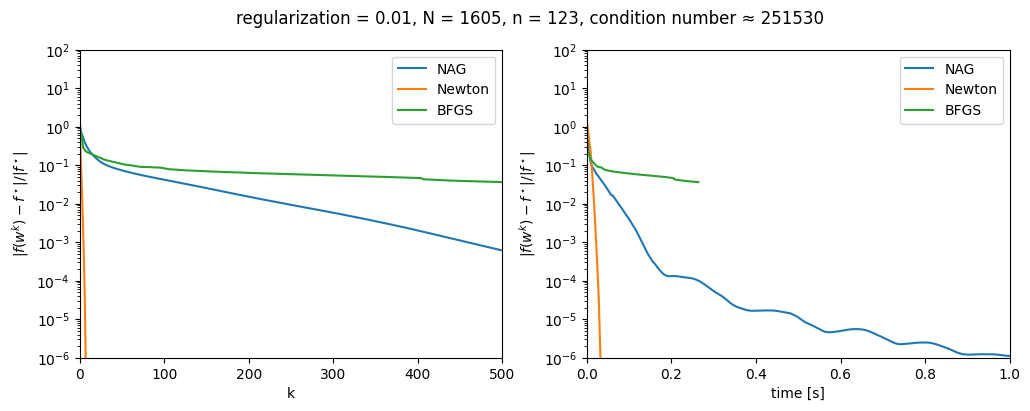

In [17]:
test_dataset_BFGS("a1a", 0.01, compare_to_previous=True)

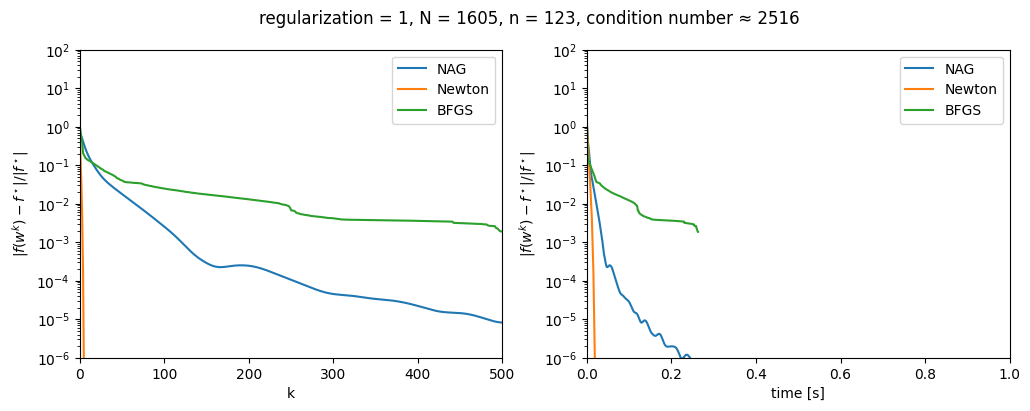

In [18]:
test_dataset_BFGS("a1a", 1, compare_to_previous=True)

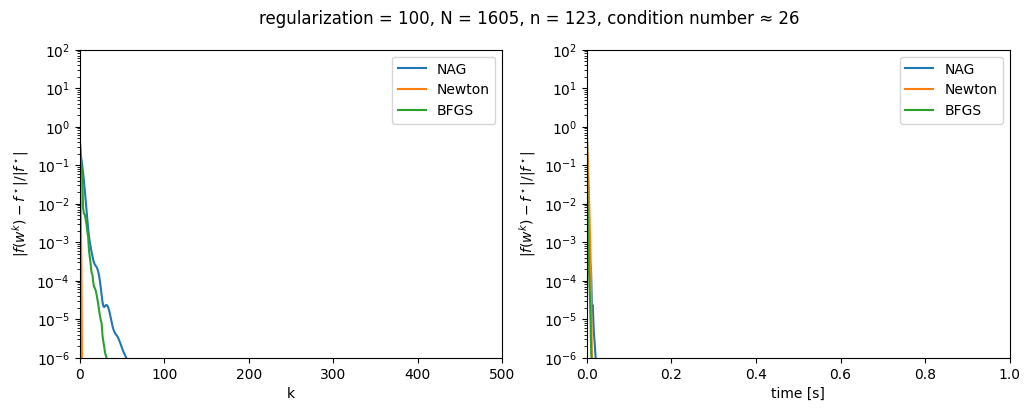

In [19]:
test_dataset_BFGS("a1a", 100, compare_to_previous=True)

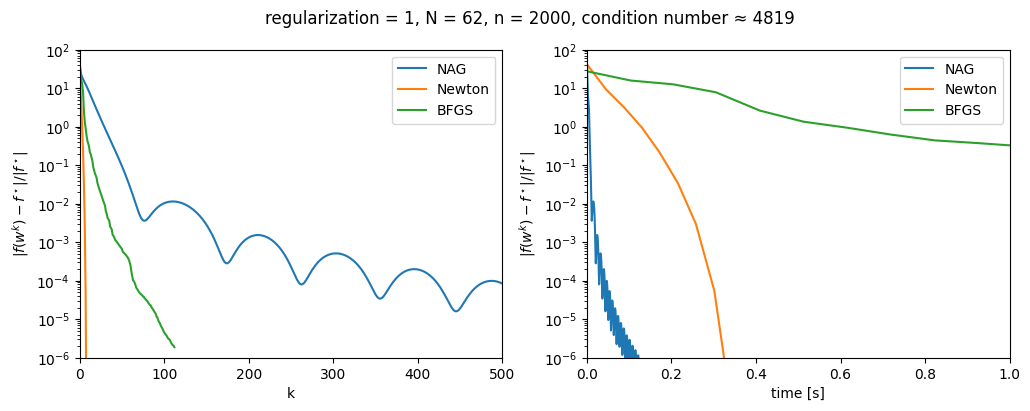

In [20]:
test_dataset_BFGS("colon", 1, compare_to_previous=True)

The current implementation of BFGS does not ensure that $H_k$ remains positive definite. One way to ensure that $H_k$ remains positive definite is by ensuring that the learning rate $\eta_k$ satisfies the Wolfe conditions ($0 < \sigma < \zeta < 1$)

\begin{align*}
    f(w^k + \eta_k d^k) {}\leq{}& f(w^k) + \eta_k \sigma \nabla f(w^k)^\top d^k\\
    \nabla f(w^k + \eta_k d^k)^\top d^k {}\geq{}& \zeta \nabla f(w^k)^\top d^k
\end{align*}
Common choices are $\sigma = 10^{-4}$, $\eta_k = 0.1$. To ensure that these conditions hold, one can employ the so-called bisection method, which is given as follows.

---

**Bisection method for Wolfe conditions**<br>
**Input:** $0<\sigma<\zeta<1$, $\underline{\eta}=0$, $\overline{\eta}=+\infty$, $\eta_{init}=1$ <br>
1. $\eta_k \leftarrow \eta_{init}$
2. **while** $k < $ max_iter **do** <br>
    $w_{trial} = w_k + \eta_k d_k$ <br>
    **if** $f(w^k + \eta d^k) > f(w^k) + \eta \sigma \nabla f(w^k)^\top d^k$ **do**<br>
    &emsp;$\overline{\eta} \leftarrow \eta$&emsp;&emsp; (decrease step) <br>
    &emsp;$\eta_k \leftarrow \tfrac{1}{2}(\underline{\eta}+\overline{\eta})$<br>
    **else if** $\nabla f(w^k+\eta d^k)^\top d^k < \zeta\nabla f(w^k)^\top d^k$ **do**<br>
    &emsp;$\underline{\eta} \leftarrow \eta$&emsp;&emsp; (increase step) <br>
    &emsp;**if** $\overline{\eta} = +\infty$ **do**<br>
    &emsp;&emsp;$\eta_k \leftarrow 2\underline{\eta}$<br>
    &emsp;**else**<br>
    &emsp;&emsp;$\eta_k \leftarrow \tfrac{1}{2}(\underline{\eta}+\overline{\eta})$<br>
3. **Return** $w_{trial}$

---

**Task 1c**: Update your implementation of BFGS from task 1a, using the bisection method instead of the Armijo linesearch.

In [21]:
def bisection_method(f, grad, search_direction : np.ndarray, w0 : np.ndarray, fw0 : float, directional_derivative_w0 : float, sigma: float, eta: float):
    max_iter = 1000
    eta = 1
    eta_l = 0
    eta_u = np.inf

    trial_w = w0
    for iter in range(max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        trial_w = None
        
        ##################################################

        trial_w = w0 + eta * search_direction
        if f(trial_w) > fw0 + eta * sigma * directional_derivative_w0:
            eta_u = eta
            eta = (1/2) * (eta_l + eta_u)
        elif grad(trial_w).T @ search_direction < eta * directional_derivative_w0:
            eta_l = eta
            if eta_u == np.inf:
                eta = 2 * eta_l
            else:
                eta = (1/2) * (eta_l + eta_u)
        else:
            break

    return trial_w

In [26]:
def BFGS(f, grad, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0
    
    # Evaluate f and gradient
    fw= f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Initialize BFGS matrix
    H = np.eye(w0.shape[0])

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        w_prev = w
        gradw_prev = gradw
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Find search direction and perform step using Armijo
        search_direction = -(H @ gradw)
        directional_derivative = gradw.T @ search_direction
        w = bisection_method(f, grad, search_direction, w, fw, directional_derivative, 10**-4, 1e-1)
        
        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Update BFGS matrix
        s = np.reshape(w - w_prev, (-1, 1))
        p = np.reshape(gradw - gradw_prev, (-1, 1))
        rho = 1 / (p.T @ s)
        V = np.eye(w0.shape[0]) - rho * s @ p.T
        H = V.T @ H @ V + rho * s @ s.T

        ##################################################

    if print:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

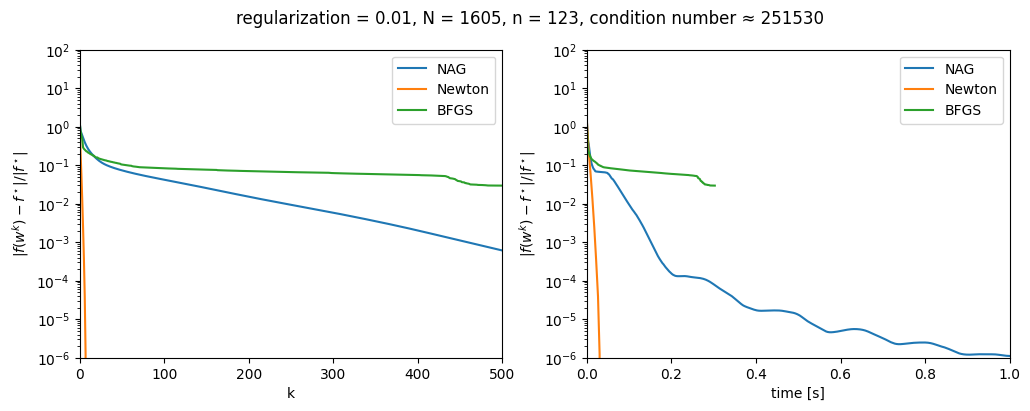

In [27]:
test_dataset_BFGS("a1a", 0.01)

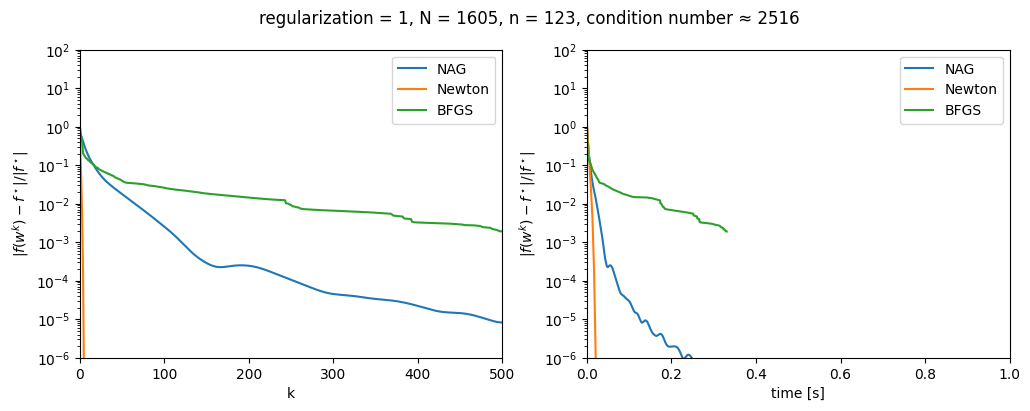

In [28]:
test_dataset_BFGS("a1a", 1)

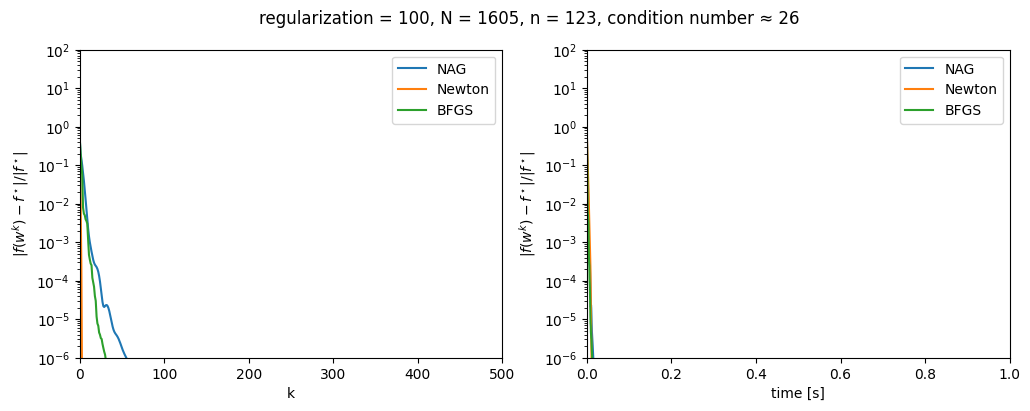

In [29]:
test_dataset_BFGS("a1a", 100)

### Exercise 2: Limited Memory BFGS (L-BFGS)

In the previous exercise, you have observed some of the advantages of BFGS, which include
- only first-order information being needed;
- and a local superlinear convergence rate.

However, the method also has some drawbacks:
- it cannot take sparsity of the Hessian into account;
- it has large memory requirements;
- and the iterations are expensive.

In particular, these last two points are related to the fact that we are working with matrices $H_k \in \mathbb{R}^{n \times n}$, which quickly becomes expensive as the dimension $n$ increases. Limited Memory BFGS, or L-BFGS for short, addresses this issue by only keeping a *past window of most recent pairs*
$$
    (s_j, p_j), \quad j = 0, \dots, m-1
$$
where $m > 0$ denotes the window size.
At every iteration $k$, LBFGS starts from some $H_{k, 0}$ and constructs a quasi-Newton approximant by performing BFGS updates
\begin{equation*}
    H_{k,j+1} = V_j^\top H_{k,j} V_j + \rho_j s_j s_j^\top, \quad j = 0, \dots m - 1.
\end{equation*}
A common initialization is
$$
    H_{k,0} = \frac{s_{k-1}^\top p_{k-1}}{p_{k-1}^\top p_{k-1}}.
$$
A very interesting property of L-BFGS is that the following L-BFGS recursion can be used to compute matrix-vector products $H_{k, m}g$, without explicitly constructing $H_{k, m}$.

---

**L-BFGS recursion**<br>
**Initialize**: $(s_j, p_j), j = 0, \dots m$, $H_0$, $g = \nabla f(w_k)$
$q \leftarrow g$ <br>
**for** $j = m-1, \dots, 0$ **do** <br>
        $\eta_j = q^\top s_j$ <br>
        $q \leftarrow q - \rho_j \eta_j p_j$ <br>
**end** <br>
$\bar q = H_0 q$ <br>
**for** $j = 0, \dots, m-1$ **do** <br>
        $\bar q \leftarrow \bar q + \rho_j(\eta_j - \bar q^\top p_j) s_j$ <br>
**end** <br>
**Return** $\bar q$

---

The full L-BFGS method is given by the algorithm below. Essentially, it is the same as BFGS, with the difference that the L-BFGS recursion is used for computing the direction $d_k$, and that past pairs $(s_k, p_k)$ must be stored.

---

**Minimization using L-BFGS**<br>
**Initialize**: $w_0$, $\epsilon = 10^{-4}$ and pre-compute $\nabla f(w_0)$
1. **while** $k < $ max_iter **do** <br>
        Compute $d_k = -H_{k} \nabla f(w_k)$ using the L-BFGS recursion <br>
        Find $w_{k+1}$ using the Armijo linesearch <br>
        Compute $\nabla f(w_{k+1})$ <br>
        **if** $\|\nabla f(w_{k+1})\| < \epsilon$ **do**<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Terminate <br>
        **else** <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute and store $s_k$, $p_k$ as in (1.2)
2. **Return** $w_{k+1}$, $f(w_{k+1})$

---

**Task 2a**: Implement the L-BFGS method by completing the functions below.

In [30]:
def LBFGS(f, grad, w0 : np.ndarray, tolerance : float, max_iter : int, m: int = 10, print_flag=False):
    w = w0

    # Evaluate f and gradient
    fw= f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Initialize L-BFGS storage
    P = np.zeros((w0.shape[0], 0))
    S = np.zeros((w0.shape[0], 0))
    rho = np.zeros(0)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        w_prev = w
        gradw_prev = gradw

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Compute search direction
        q = gradw.copy()
        eta = np.zeros(S.shape[1])

        # First loop
        for j in range(S.shape[1]-1, -1, -1):
            eta[j] = rho[j] * S[:, j].T @ q
            q = q - eta[j] * P[:, j]

        # Initialize H0
        if S.shape[1] > 0:
            H0_scale = (S[:, -1].T @ P[:, -1]) / (P[:, -1].T @ P[:, -1])
            r = H0_scale * q
        else:
            r = q  # Use identity matrix if no history

        # Second loop
        for j in range(S.shape[1]):
            beta = rho[j] * P[:, j].T @ r
            r = r + S[:, j] * (eta[j] - beta)

        search_direction = -r
        directional_derivative = gradw.T @ search_direction

        # perform step using bisection
        w = bisection_method(f, grad, search_direction, w, fw, directional_derivative, 10**-4, 1e-1)

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Update L-BFGS data structures
        s = w - w_prev
        p = gradw - gradw_prev

        # Only store if s^T p is sufficiently positive (curvature condition)
        if s.T @ p > 1e-10:
            # Convert to column vectors
            s = s.reshape(-1, 1)
            p = p.reshape(-1, 1)

            # Add new vectors
            S = np.hstack((S, s))
            P = np.hstack((P, p))
            rho = np.append(rho, 1.0 / (p.T @ s)[0, 0])

            # Remove oldest vectors if we exceed memory limit
            if S.shape[1] > m:
                S = S[:, 1:]
                P = P[:, 1:]
                rho = rho[1:]

        ##################################################

    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

In [31]:
def test_dataset_LBFGS(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f, g, h = lambda w: logistic_regression_fun(w, X, y, mu), lambda w: logistic_regression_grad(w, X, y, mu), lambda w: logistic_regression_hess(w, X, y, mu), 

    if compare_to_previous:
        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        hist_n = newton(f, g, h, w0, 1e-08, 100, print=False)
        primal_gap_reg_n = [(f - f_star) / f_star for f in hist_n['f']]

        hist_g_bfgs = BFGS(f, g, w0, 1e-4, 500, print=False)
        primal_gap_reg_bfgs = [(f - f_star) / f_star for f in hist_g_bfgs['f']]

        hist_g_lbfgs = LBFGS(f, g, w0, 1e-4, 500, print_flag=False)
        primal_gap_reg_lbfgs = [(f - f_star) / f_star for f in hist_g_lbfgs['f']]

        # Plot results
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_n, hist_n['time'], 'Newton', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_bfgs, hist_g_bfgs['time'], 'BFGS', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_lbfgs, hist_g_lbfgs['time'], 'L-BFGS', fig_num=1, overwrite=False)
    else:
        hist_g_lbfgs = LBFGS(f, g, w0, 1e-4, 500, print_flag=False)
        primal_gap_reg_lbfgs = [(f - f_star) / f_star for f in hist_g_lbfgs['f']]
    
        # Plot results
        plot_results(primal_gap_reg_lbfgs, hist_g_lbfgs['time'], 'L-BFGS', fig_num=1, overwrite=True, suptitle=suptitle)

**Task 1b**: Test your L-BFGS implementation on logistic regression. How does it compare to the other algorithms you implemented?

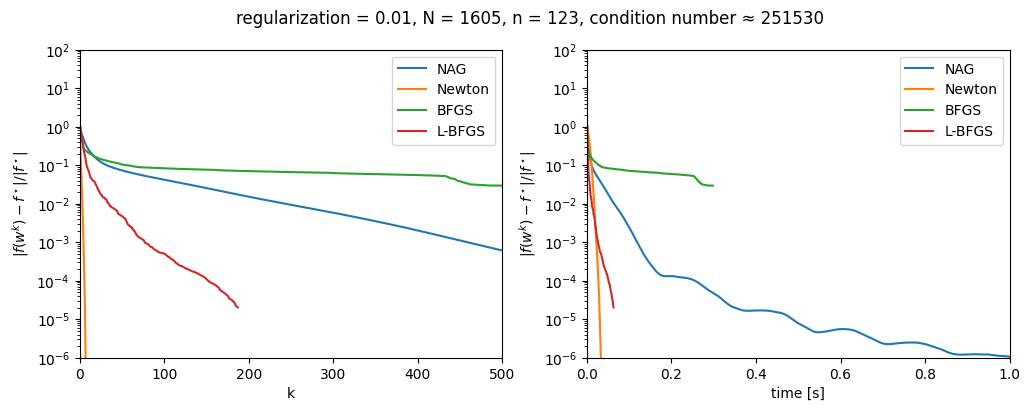

In [32]:
test_dataset_LBFGS("a1a", 0.01, compare_to_previous=True)

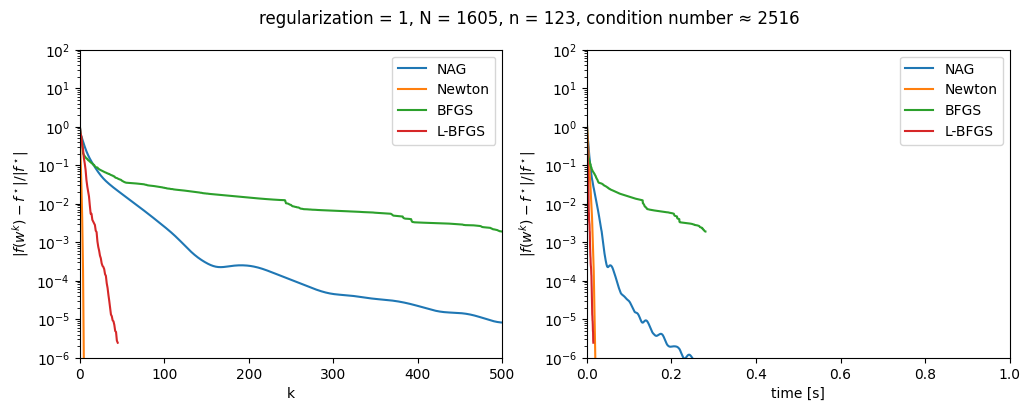

In [33]:
test_dataset_LBFGS("a1a", 1, compare_to_previous=True)

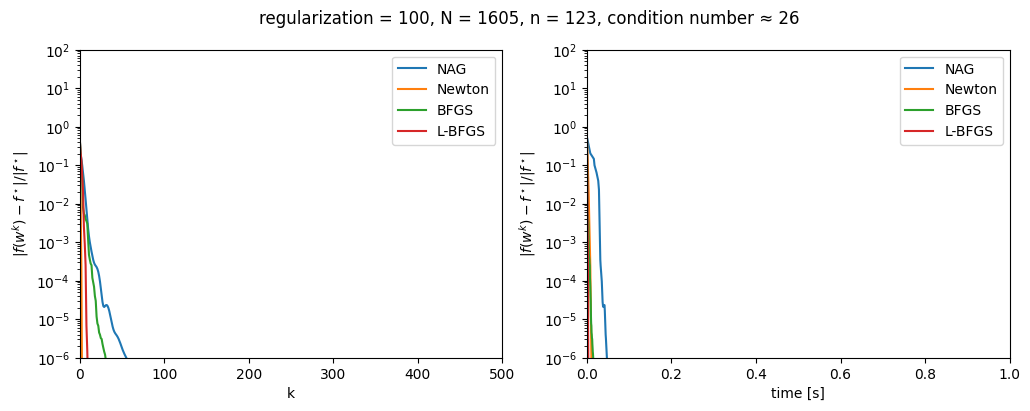

In [34]:
test_dataset_LBFGS("a1a", 100, compare_to_previous=True)

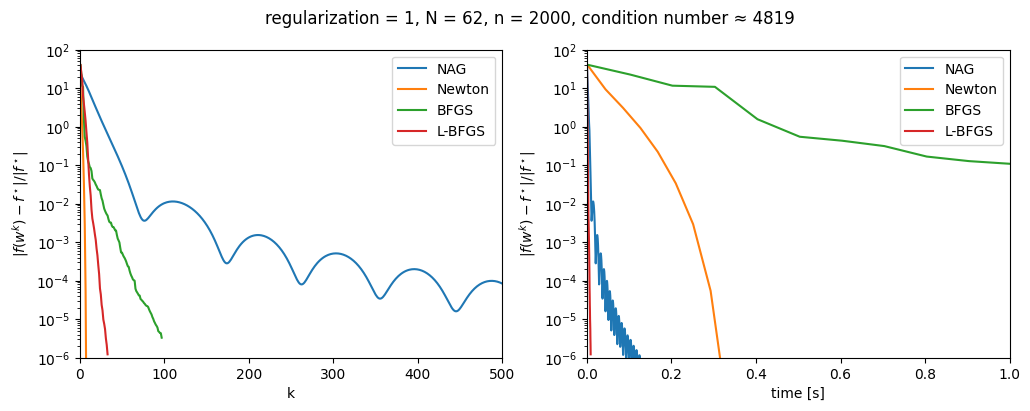

In [35]:
test_dataset_LBFGS("colon", 1, compare_to_previous=True)

### Exercise 3: Stochastic Gradient Descent

Let us have another look at the logistic regression objective
$$
    f(w) = \frac{1}{N} \sum_{i=1}^N \log(1 + \exp(-y_i(w^\top x_i))) + \frac{\mu}{2N}\|w\|_2^2.
$$
The function $f$ has an additive structure, representable in so-called finite-sum form via $f(w) = \tfrac{1}{N}\sum_{i=1}^N f_i(w) + \frac{\mu}{2N}\|w\|^2$ with
$$
    f_i(w) = \log(1 + \exp(-y_i(w^\top x_i))).
$$
Observe that the computation of $f_i$ is significantly cheaper than that of a full gradient $\nabla f$.
In fact, in some applications, there are so many data points, i.e., $N$ is so large, that the computation of a full gradient at each iteration becomes simply intractable.

One of the simplest and most popular methods that tackle this type of problems is Stochastic gradient descent (SGD):

1. Choose (randomly) $i \in \{1, \dots, N\}$

2. Update $w_{k+1} = w_k - \alpha_k (\nabla f_i(w_k) + \tfrac{\mu}{N} w_k)$

The stepsize $\alpha_k$, also known as the learning rate, is in general a decreasing sequence. A standard choice is $\alpha_k = \alpha_0 \tfrac{1}{\sqrt{k}}$.

In practice, using only one $\nabla f_i(x)$ per iteration can be quite slow. A way to speed up convergence is by utilizing a *batch* of gradients, i.e. by combining  $\nabla f_i$ for $i \in J \subset \{1, \dots, N\}$ with $|J| > 1$. This scheme is captured in the following update:
1. Choose (randomly) $J \subset \{1, \dots, N\}$

2. Update $w_{k+1} = w_k - \alpha_k (\sum_{i \in J} \tfrac{\nabla f_i(w_k)}{\vert J \vert} + \tfrac{\mu}{N} w^k)$.

Remark that for $\vert J \vert = N$, we recover the (deterministic) GD method with learning rate $\alpha_k$.

**Task3a**: Derive an expression for $\nabla f_{i}$ and implement *logistic_loss_grad_i* for evaluating it. Also implement *logistic_regression_grad_J* which implements a batched gradient
$
\sum_{i \in J} \tfrac{\nabla f_i(w_k)}{\vert J \vert} + \tfrac{\mu}{N} w_k.
$

$$\nabla f_i(w) = -y_i x_i \cdot \frac{\exp(-y_i(w^\top x_i))}{1 + \exp(-y_i(w^\top x_i))}$$

In [ ]:
def logistic_loss_grad_i(w, X, y, i):
    [N, n] = X.shape

    ##################################################
    ### TODO: Write your code here
    ##################################################
    e = np.exp(-y[i] * (X[i, :] @ w))
    grad_i = -y[i] * X[i, :] * ( e / (1 + e) )
    return grad_i

    ##################################################

def logistic_regression_grad_J(w, X, y, mu, J: list[int]):
    [N, n] = X.shape

    ##################################################
    ### TODO: Write your code here
    ##################################################
    grad_J = sum(logistic_loss_grad_i(w, X, y, i) for i in J) / len(J) + (mu/N) * w
    return grad_J

    ##################################################

In [ ]:
def plot_results(primal_gap_reg, time_points, method_name, suptitle = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if suptitle is not None:
            fig.suptitle(suptitle)
    ax1.semilogy(primal_gap_reg, label=method_name)
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$|f(x^k) - f^\star|/|f^\star|$')
    ax1.set_xlim(left=0, right = 500)
    ax1.set_ylim(top = 1e2, bottom = 1e-4)
    ax1.legend()

    ax2.semilogy(time_points, primal_gap_reg, label=method_name)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel(r'$|f(x^k) - f^\star|/|f^\star|$')
    x_lim_max = 10
    if time_points[-1] < x_lim_max:
        x_lim_max = time_points[-1]
    ax2.set_xlim(left=0, right = x_lim_max)
    ax2.set_ylim(top = 1e2, bottom = 1e-4)
    ax2.legend()

**Task 3b**: Implement SGD by completing the code in *sgd*. If *eta_decreasing* is true, use $\eta_k = \tfrac{\eta_0}{\sqrt{k}}$; otherwise set $\eta_k = \eta_0$.

In [ ]:
def sgd(f, gradJ, full_g, N, n, w0 : np.ndarray, eta0 : float, tolerance : float, max_iter : int, batch_size: int = 1, print_flag = True, eta_decreasing = True):
    w = w0
    
    # Evaluate f
    fw = f(w)

    # Choose J at random and compute gradient
    J = random.sample(range(1, N), batch_size)
    gradJw = gradJ(w, J)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(1, max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Compute the learning rate at current iterate
        if eta_decreasing:
            eta = eta0 / np.sqrt(iter)
        else:
            eta = eta0

        # Perform gradient step to update w
        w = w - eta * gradJw

        # Choose J at random and compute gradient
        J = random.sample(range(1, N), batch_size)
        gradJw = gradJ(w, J)

        # Evaluate f
        fw = f(w)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['time'].append(toc-tic)
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

In [39]:
def test_dataset_sgd(dataset, mu, batch_size = 1, eta0=None, eta_decreasing = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu))) + ', batch size = ' + str(batch_size)
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f, g, full_g = lambda w: logistic_regression_fun(w, X, y, mu), lambda w, J: logistic_regression_grad_J(w, X, y, mu, J), lambda w: logistic_regression_grad(w, X, y, mu)

    if eta0 is None:
        eta0 = 1 / Lf

    hist_g = sgd(f, g, full_g, X.shape[0], X.shape[1], w0, eta0, 1e-08, 500, print_flag=False, batch_size=batch_size, eta_decreasing=eta_decreasing)
    primal_gap_reg = [(x - f_star) / f_star for x in hist_g['f']]
    
    plot_results(primal_gap_reg, hist_g['time'], 'SGD', suptitle=suptitle)

**Task 3c**: Test the method on the logistic regression problem, for $\mu \in \{0.01, 1, 100 \}$. Compare both fixed and decreasing learning rates.

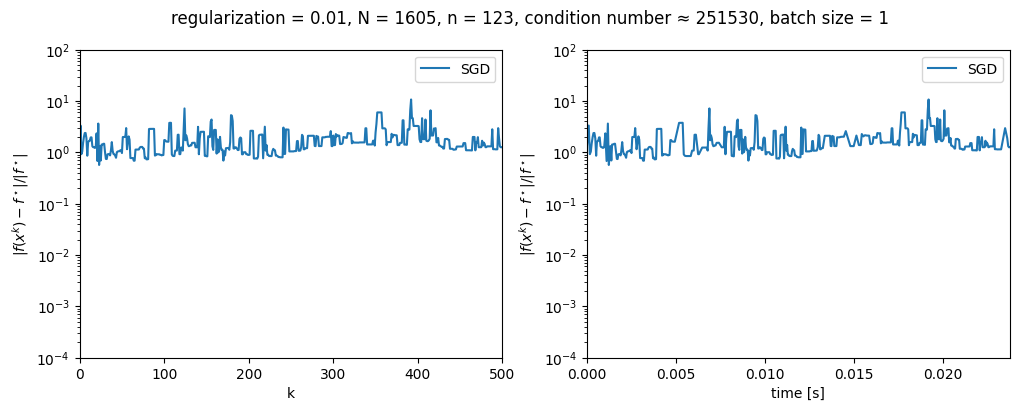

In [40]:
test_dataset_sgd("a1a", 0.01, eta_decreasing=False)

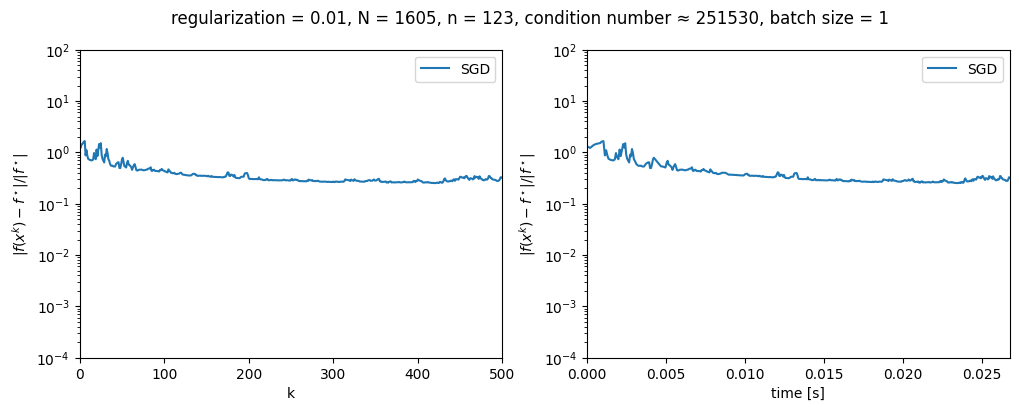

In [41]:
test_dataset_sgd("a1a", 0.01, eta_decreasing=True)

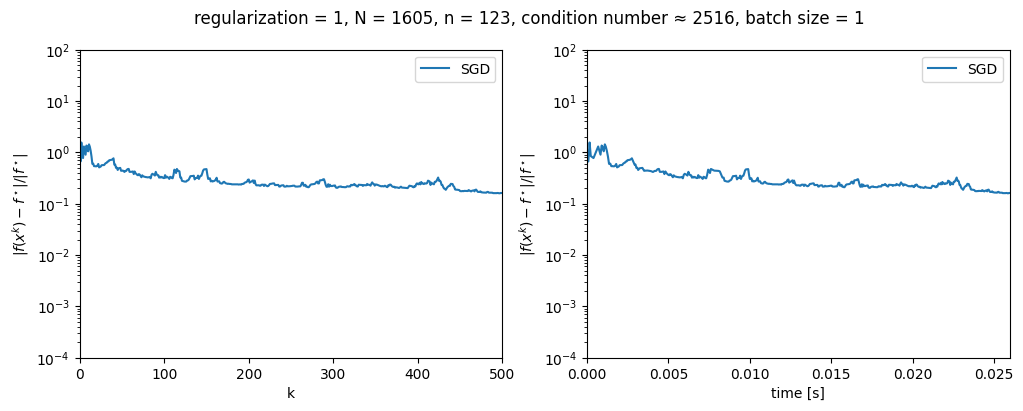

In [42]:
test_dataset_sgd("a1a", 1, eta_decreasing=True)

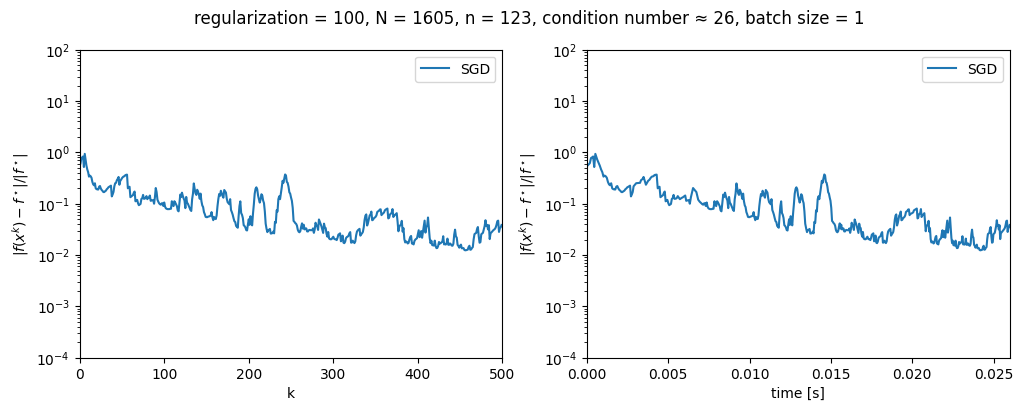

In [43]:
test_dataset_sgd("a1a", 100, eta_decreasing=True)

Note: A fixed step size does not work in this case!

**Task 1c**: Now compare batched SGD for various batch sizes. What do you observe?

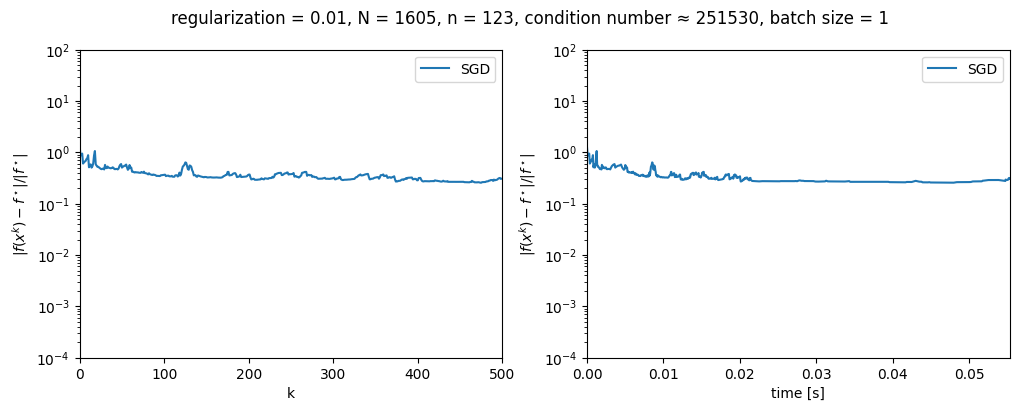

In [44]:
test_dataset_sgd("a1a", 0.01, batch_size=1)

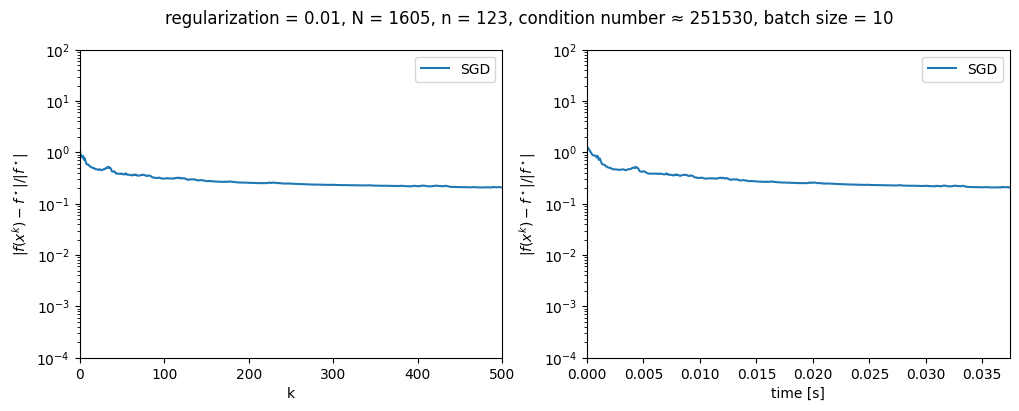

In [45]:
test_dataset_sgd("a1a", 0.01, batch_size=10)

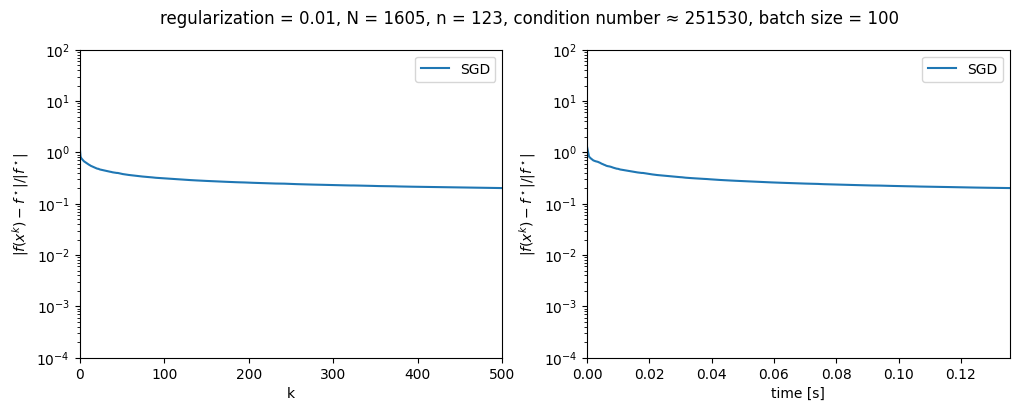

In [46]:
test_dataset_sgd("a1a", 0.01, batch_size=100)

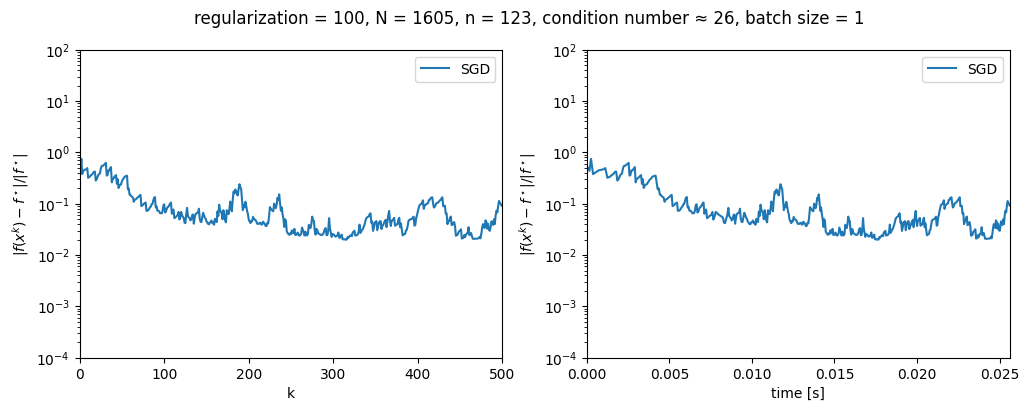

In [47]:
test_dataset_sgd("a1a", 100, batch_size=1)

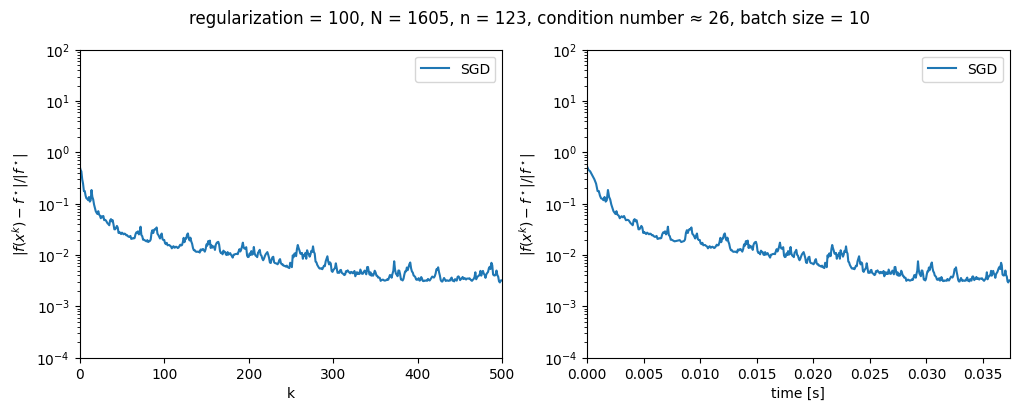

In [48]:
test_dataset_sgd("a1a", 100, batch_size=10)

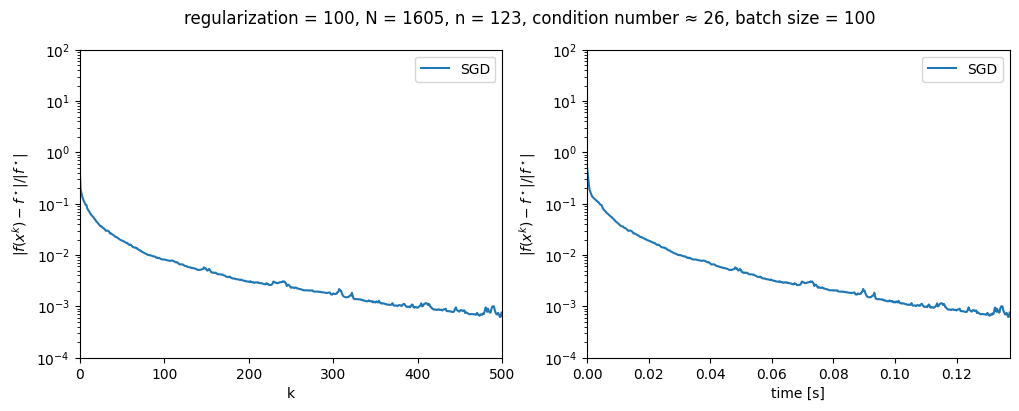

In [49]:
test_dataset_sgd("a1a", 100, batch_size=100)

## Exercise 4: Momentum SGD
In the previous exercise session we observed how momentum can accelerate convergence in the deterministic setting. Similar techniques can be used in the stochastic setting that we explore here. One of these methods is momentum SGD and is presented below. For simplicity, we restrict ourselves to the case where $\vert J \vert = 1$.
1. Choose (randomly) $i \in \{1, \dots, N\}$.

2. Update $z_{k+1} = \gamma z_k + \eta_k (\nabla f_i(w_k) + \tfrac{\mu}{N} w_k)$.

3. Update $w_{k+1} = w_k - z_{k+1}$,
where $\gamma$ is usually chosen close to $0.9$.

**Task 4a**: Implement Momentum SGD by completing the code in *momentum_sgd*.

In [ ]:
def momentum_sgd(f, gradJ, full_g, N, n, w0 : np.ndarray, eta0 : float, tolerance : float, max_iter : int, print_flag = True, batch_size = 1):
    w = w0
    z = np.copy(w0)

    # Evaluate f
    fw = f(w)

    # Choose J at random and compute gradient
    J = random.sample(range(1, N), batch_size)
    gradJw = gradJ(w, J)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(1, max_iter):
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Compute the learning rate at current iterate
        eta = eta0 / np.sqrt(iter)

        # Perform gradient step to update w
        w_prev = np.copy(w)
        w = w - eta * gradJw
        z = w + (iter - 1) / (iter + 2) * (w - w_prev)
        gradJw = gradJ(z, J)

        # Choose J at random and compute gradient
        J = random.sample(range(1, N), batch_size)

        # Evaluate f
        fw = f(w)
        
        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['time'].append(toc-tic)

    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 4b**: Test the Momentum SGD method for $\mu = 1$. What do you observe compared to the vanilla SGD method?

In [51]:
def test_dataset_momentum_sgd(dataset, mu, batch_size = 1, eta0=None, eta_decreasing = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu))) + ', batch size = ' + str(batch_size)
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f, g, full_g = lambda w: logistic_regression_fun(w, X, y, mu), lambda w, J: logistic_regression_grad_J(w, X, y, mu, J), lambda w: logistic_regression_grad(w, X, y, mu)

    if eta0 is None:
        eta0 = 1 / Lf
    
    hist_g = momentum_sgd(f, g, full_g, X.shape[0], X.shape[1], w0, eta0, 1e-08, 500, print_flag=False)
    primal_gap_reg = [(x - f_star) / f_star for x in hist_g['f']]
    
    # Plot results
    plot_results(primal_gap_reg, hist_g['time'], 'MomentumSGD', suptitle=suptitle)

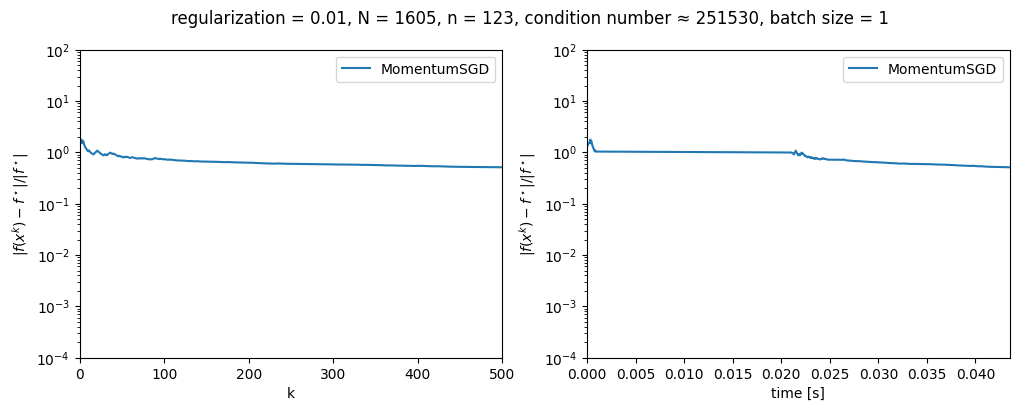

In [52]:
test_dataset_momentum_sgd("a1a", 0.01, eta0=0.1, batch_size=1)

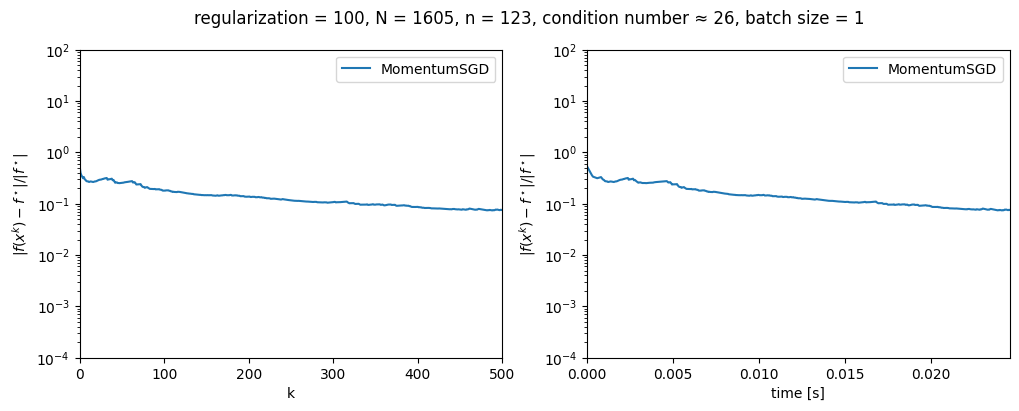

In [53]:
test_dataset_momentum_sgd("a1a", 100, eta0=0.1, batch_size=1)

## Exercise 5: Adagrad
Although the variants of SGD we worked with so far are quite effective in tackling large-scale optimization problems, they all suffer from the same issue: the learning rate sequence $(\eta_k)_{k \in \mathbb{N}}$ has to be predefined. One popular method that overcomes this problem is Adagrad, which overcomes this problem by adaptively updating the learning rate using information from the stochastic gradients.

1. Choose (randomly) $i \in \{1, \dots, N\}$

2. Update gradient history vector $g_{k+1} = g_k + (\nabla f_i(w_k) + \tfrac{\mu}{N} w_k)$
3. Update $w_{k+1} = w_k - \tfrac{\eta}{\sqrt{\varepsilon + g_{k+1}}} \odot (\nabla f_i(w_k) + \tfrac{\mu}{N} w_k)$ where $\odot$ denotes the elementwise multiplication of two vectors.

**Task 5a**: Implement adagrad by completing the code below.

In [ ]:
def adagrad(f, gradJ, full_g, N, epsilon, w0 : np.ndarray, eta0 : float, tolerance : float, max_iter : int, print_flag = False, batch_size=1):
    w = w0
    
    # Evaluate f
    fw = f(w)

    # Choose J at random and compute gradient
    J = random.sample(range(1, N), batch_size)
    gradJw = gradJ(w, J)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'time':[0]}
    tic = time.perf_counter()

    # Create initial vector of gradients
    grad_hist = np.zeros_like(w0)

    for iter in range(1, max_iter):
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Add stochastic gradient to vector of gradient history
        
        # Perform gradient step to update x

        # Choose J at random and compute gradient

        # Evaluate f

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['time'].append(toc-tic)
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

In [ ]:
def test_dataset_adagrad(dataset, mu, batch_size = 1, eta0=None, eta_decreasing = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu))) + ', batch size = ' + str(batch_size)
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f, g, full_g = lambda w: logistic_regression_fun(w, X, y, mu), lambda w, J: logistic_regression_grad_J(w, X, y, mu, J), lambda w: logistic_regression_grad(w, X, y, mu)

    if eta0 is None:
        eta0 = 1 / Lf

    hist_g = adagrad(f, g, full_g, X.shape[0], 1e-06, w0, eta0, 1e-08, 500, print_flag=False)
    primal_gap_reg = [(x - f_star) / f_star for x in hist_g['f']]
    

    # Plot results
    plot_results(primal_gap_reg, hist_g['time'], 'MomentumSGD', suptitle=suptitle)

**Task 5b**: Run Adagrad, and vary $\eta$ and the batch size. What do you observe? 

In [ ]:
test_dataset_adagrad("a1a", 100, eta0=0.1, batch_size=1)